<a href="https://colab.research.google.com/github/machine-perception-robotics-group/MPRGDeepLearningLectureNotebook/blob/master/12_gan/03_Deep_Convolutional_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Convolutional Generative Adversarial Networks (DC-GAN)
## 目的
DC-GANによって画像の生成をして動作を理解する．

## 必要なモジュールのインポート
Pytorchで学習するときに必要となるモジュールをインポートします．

In [1]:
import numpy as np
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

## ネットワークの構築
オリジナルのGANは，全結合層とReLUのみで構築される非常にシンプルなネットワークでした．<br>
シンプルな反面で，学習が不安定になったり，高解像な画像生成とは言い難いものでした．

Deep Convolutional GAN (DC-GAN)は，名前の通り畳み込み処理を用いたネットワークの構築することによって，オリジナルのGANより綺麗な画像を生成することを可能としました．
他にもDC-GANは，以下に示す点でもオリジナルのGANと異なります．
* Batch Normalizationを利用する．（Discriminatorの1層目と最終層は除く）
* Discriminatorの活性化関数は，Leaky ReLUを使用する．
* Generatorの最終層はtanh関数を使用する．（それ以外の層は全てReLU）
* Deconvolutionの使用，PoolingではなくConvolutionによるDownsampling

これらを考慮してDiscriminatorとGeneratorのネットワークを構築します．<br>
GeneratorとDiscriminator共に重みパラメータは平均が0，偏差が0.02の正規分布で，バイアスは0で初期化します．

In [2]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, out_ch=3, img_size=32):
        super(Generator, self).__init__()
        n_layer = int(np.log2(img_size)) - 2
        self.model = nn.Sequential()
        
        features = 512
        self.model.add_module('Deconv_first', nn.ConvTranspose2d(latent_dim, features, 2, 2, bias=True))
        self.model.add_module('BN_first', nn.BatchNorm2d(features))
        self.model.add_module('Act_first', nn.ReLU(inplace=True))
  
        in_features = features
        for i in range(n_layer):
            out_features = in_features // 2
            self.model.add_module('Deconv%d' % i, nn.ConvTranspose2d(in_features, out_features, 4, 2, 1, bias=True))
            self.model.add_module('BN%d' % i, nn.BatchNorm2d(out_features))
            self.model.add_module('Act%d' % i, nn.ReLU(inplace=True))
            in_features = out_features
        
        self.model.add_module('Deconv_last', nn.ConvTranspose2d(in_features, out_ch, 2, 2, bias=True))
        self.model.add_module('Act_last', nn.Tanh())
        self.weight_init()

    def weight_init(self):
        for m in self.model:
          if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0.0, 0.02)
            m.bias.data.zero_()

    def forward(self, z):
        return self.model(z)
    
class Discriminator(nn.Module):
    def __init__(self, in_ch=3, img_size=32):
        super(Discriminator, self).__init__()
        n_layer = int(np.log2(img_size)) - 2
        self.model = nn.Sequential()
        
        features = 32
        self.model.add_module('Conv_first', nn.Conv2d(in_ch, features, 4, 2, 1, bias=True))
        self.model.add_module('Act_first', nn.LeakyReLU(negative_slope=0.2))
  
        in_features = features
        for i in range(n_layer):
            out_features = in_features * 2
            self.model.add_module('Conv%d' % i, nn.Conv2d(in_features, out_features, 4, 2, 1, bias=True))
            self.model.add_module('BN%d' % i, nn.BatchNorm2d(out_features))
            self.model.add_module('Act%d' % i, nn.LeakyReLU(negative_slope=0.2))
            in_features = out_features
        
        self.model.add_module('Conv_last', nn.Conv2d(in_features, 1, 2, 1, bias=True))
        self.weight_init()
  
    def weight_init(self):
        for m in self.model:
          if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0.0, 0.02)
            m.bias.data.zero_()

    def forward(self, x):
        return self.model(x).view(-1)

## データセットと最適化関数
データセットにはMNISTを使用します．
最適化関数はAdam optimizer使用し，学習率$2\times 10^4$，betaの値を$0.5, 0.999$として学習します．

In [6]:
transform_training = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor()])
mnist_data = datasets.MNIST(root='./data', train=True, transform=transform_training, download=True)
training_data = DataLoader(mnist_data, batch_size=128, shuffle=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
latent_dim = 100
G = Generator(latent_dim=latent_dim, out_ch=1, img_size=32).to(device)
D = Discriminator(in_ch=1, img_size=32).to(device)
opt_g = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
opt_d = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
print('=' * 50)
print(G)
print('=' * 50)
print(D)
print('=' * 50)

Generator(
  (model): Sequential(
    (Deconv_first): ConvTranspose2d(100, 512, kernel_size=(2, 2), stride=(2, 2))
    (BN_first): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (Act_first): ReLU(inplace=True)
    (Deconv0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (BN0): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (Act0): ReLU(inplace=True)
    (Deconv1): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (BN1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (Act1): ReLU(inplace=True)
    (Deconv2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (BN2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (Act2): ReLU(inplace=True)
    (Deconv_last): ConvTranspose2d(64, 1, kernel_size=(2, 2), stride=(2, 2))
    (Act_last): Tanh()
  )
)
Dis

## GANの学習
学習のプロセスは，オリジナルのGANと同じです．

In [7]:
n_epoch = 20
n_critic = 1
criterion = nn.BCEWithLogitsLoss()
print(device)
for epoch in range(1, n_epoch+1):
    Tensor = torch.cuda.FloatTensor
    G.train()
    D.train()
    for idx, (real_x, _) in enumerate(training_data):
        real_x = real_x.to(device)
        batch = real_x.size(0)
        flag_real = Tensor(batch).fill_(1.0)
        flag_fake = Tensor(batch).fill_(0.0)
        
        for _ in range(n_critic):
            D.zero_grad()
            z = torch.randn(batch, latent_dim, 1, 1).to(device)
            fake_x = G(z)
            out_real = D(real_x)
            out_fake = D(fake_x.detach())
            loss_real = criterion(out_real, flag_real)
            loss_fake = criterion(out_fake, flag_fake)
            dis_loss = loss_real + loss_fake
            dis_loss.backward()
            opt_d.step()
            
        G.zero_grad()
        z = torch.randn(batch, latent_dim, 1, 1).to(device)
        fake_x = G(z)
        out_gen = D(fake_x)
        gen_loss = criterion(out_gen, flag_real)
        gen_loss.backward()
        opt_g.step()
        
        if idx % 100 == 0:
            print('Training epoch: {} [{}/{} ({:.0f}%)] | D loss: {:.6f} | G loss: {:.6f} |'\
                  .format(epoch, idx * len(real_x), len(training_data.dataset),
                  100. * idx / len(training_data), dis_loss.item(), gen_loss.item()))

cuda:0
Training epoch: 1 [0/60000 (0%)] | D loss: 1.376679 | G loss: 1.266669 |
Training epoch: 1 [12800/60000 (21%)] | D loss: 0.191996 | G loss: 2.978821 |
Training epoch: 1 [25600/60000 (43%)] | D loss: 0.289329 | G loss: 4.989992 |
Training epoch: 1 [38400/60000 (64%)] | D loss: 0.232288 | G loss: 4.363451 |
Training epoch: 1 [51200/60000 (85%)] | D loss: 0.121334 | G loss: 2.617219 |
Training epoch: 2 [0/60000 (0%)] | D loss: 0.397371 | G loss: 4.423500 |
Training epoch: 2 [12800/60000 (21%)] | D loss: 0.257330 | G loss: 3.781664 |
Training epoch: 2 [25600/60000 (43%)] | D loss: 0.091380 | G loss: 4.618008 |
Training epoch: 2 [38400/60000 (64%)] | D loss: 0.048642 | G loss: 4.939937 |
Training epoch: 2 [51200/60000 (85%)] | D loss: 0.075024 | G loss: 4.393672 |
Training epoch: 3 [0/60000 (0%)] | D loss: 0.178601 | G loss: 7.143684 |
Training epoch: 3 [12800/60000 (21%)] | D loss: 0.184344 | G loss: 4.114243 |
Training epoch: 3 [25600/60000 (43%)] | D loss: 0.210838 | G loss: 5.352

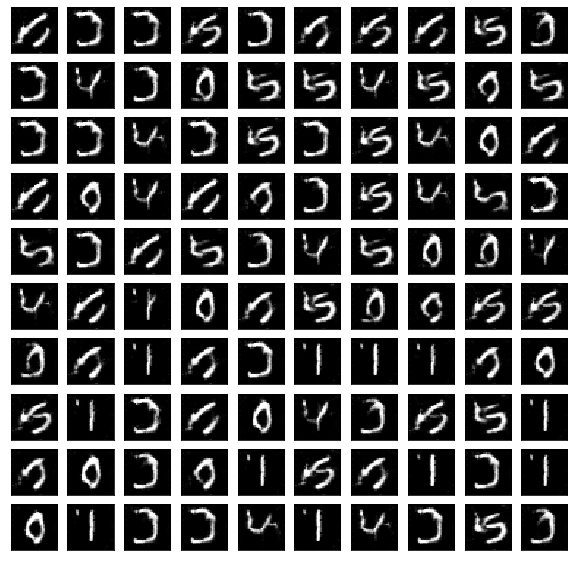

In [8]:
z = torch.randn(100, 100, 1, 1).to(device)
G.eval()
with torch.no_grad():
  test_img = G(z)
_test_img = (test_img * 256.).clamp(min=0., max=255.).squeeze().data.cpu().numpy()

fig = plt.figure(figsize=(10, 10))
for i, im in enumerate(_test_img):
    ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[])
    ax.imshow(im, 'gray')

## 課題
1. データセットをMNISTからCIFAR-10に変更して学習してみましょう．
2. 2つの潜在変数の間を補間するように画像生成した場合，どのような画像が生成されるか確認してください．

# 参考文献
[1] Alec Radford, Luke Metz and Soumith Chintala, Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks, ICLR, 2016.